In [13]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification

train_data = pd.read_csv("../data/curated/train_data_curated.csv")
test_data = pd.read_csv("../data/curated/test_data_curated.csv")

### Data Organizing

In [14]:
# Finds out all the numerical and string columns in the datasets
obj_lst = []
num_lst = []
target = "IsFraud"

for data_name, data_type in zip(train_data.columns, train_data.dtypes):
    if data_type == "object":
        obj_lst.append(data_name)
    else:
        num_lst.append(data_name)

num_lst.remove(target)
numerical_train_data = train_data[num_lst]
numerical_test_data = test_data[num_lst]

obj_train_data = train_data[obj_lst]
obj_test_data = test_data[obj_lst]

# Isolating the target column for later
fraud = train_data[[target]]

In [15]:
obj_lst

['TransactionType', 'TransactionLocation']

In [16]:
num_lst

['TransactionNumber',
 'UserID',
 'Age',
 'NumDependents',
 'Latitude',
 'Longitude',
 'UserTenure',
 'TypicalLocationFlag',
 'Income_Amount',
 'Expenditure_Amount',
 'GiftsTransaction_Amount',
 'TransactionAmount_Amount',
 'Hour',
 'Minute',
 'Year',
 'Month',
 'Day',
 'Transaction_Income_Ratio']

In [17]:
# Standardizing the numerical data to avoid skew data
scaler = StandardScaler()
scaled_features_numerical_train = scaler.fit_transform(numerical_train_data)
scaled_features_numerical_train = pd.DataFrame(scaled_features_numerical_train)

scaled_features_numerical_test = scaler.fit_transform(numerical_test_data)
scaled_features_numerical_test = pd.DataFrame(scaled_features_numerical_test)

# Using One hot encoding to replace string data
encoded_obj_train = pd.get_dummies(obj_train_data).astype(int)
obj_header = list(encoded_obj_train.columns)
encoded_obj_test = pd.get_dummies(obj_test_data).astype(int)

### Model Building

In [18]:
final_train_data = pd.concat([scaled_features_numerical_train, encoded_obj_train], axis=1)
final_test_data = pd.concat([scaled_features_numerical_test, encoded_obj_test], axis=1)

transactionID_test = test_data[["TransactionNumber"]]
final_test_data.columns = range(final_test_data.shape[1])

X = final_train_data
y = fraud

X.columns = range(X.shape[1])
y.columns = range(y.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Hyperparameter Tuning

In [19]:
rfc = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True, False]
}

# Tuning Hyperparameter for Random Forest Classifier
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0)

grid_search.fit(X, y.values.ravel())

print("Best Parameters from GridSearchCV:", grid_search.best_params_)

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
295 fits failed with the following error:
Traceback (most recent call last):
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_const

Best Parameters from GridSearchCV: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [20]:
# 0-R model
y_freq = y_train.mode().iloc[0]
y_freq = int(y_freq[0])
Zero_R_pred = [y_freq]*len(y_test)

In [21]:
# Random Forest Classifier
rf_model = RandomForestClassifier(max_depth=10,
                                  max_features='sqrt',
                                  min_samples_leaf=2,
                                  min_samples_split=5,
                                  n_estimators=100,
                                  random_state=42)

rf_model.fit(X_train, y_train)

rf_y_pred_train = rf_model.predict(X_test)

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### Model Reports

In [22]:
# 0-R
print("0-R model")
accuracy = accuracy_score(y_test, Zero_R_pred)
print(f"Accuracy: {accuracy:.5f}")

# Generate classification report
print("\nClassification Report:")
report_dict = classification_report(y_test, Zero_R_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(5)
print(report_df)

print()

# Calculate accuracy
print("Random Forest Classifier Model")
accuracy = accuracy_score(y_test, rf_y_pred_train)
print(f"Accuracy: {accuracy:.5f}")

# Generate classification report
print("\nClassification Report:")
report_dict = classification_report(y_test, rf_y_pred_train, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(5)
print(report_df)


0-R model
Accuracy: 0.62352

Classification Report:
              precision   recall  f1-score     support
0               0.62352  1.00000   0.76811  1368.00000
1               0.00000  0.00000   0.00000   826.00000
accuracy        0.62352  0.62352   0.62352     0.62352
macro avg       0.31176  0.50000   0.38405  2194.00000
weighted avg    0.38878  0.62352   0.47893  2194.00000

Random Forest Classifier Model
Accuracy: 0.99909

Classification Report:
              precision   recall  f1-score     support
0               0.99854  1.00000   0.99927  1368.00000
1               1.00000  0.99758   0.99879   826.00000
accuracy        0.99909  0.99909   0.99909     0.99909
macro avg       0.99927  0.99879   0.99903  2194.00000
weighted avg    0.99909  0.99909   0.99909  2194.00000


/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

In [23]:
importances = rf_model.feature_importances_

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_lst = num_lst + obj_header
feature_idx = {}
index = 0
for feature in feature_lst:
    feature_idx[index] = feature
    index += 1

feature_importances['Feature'] = feature_importances['Feature'].map(feature_idx)
# Get the top 5 most important features
feature_importances.head(5)

,Feature,Importance
12,Hour,0.449103
21,TransactionType_Withdrawal,0.267078
27,TransactionLocation_Melbourne,0.076889
19,TransactionType_Purchase,0.060737
20,TransactionType_Transfer,0.031970


Zero-R model


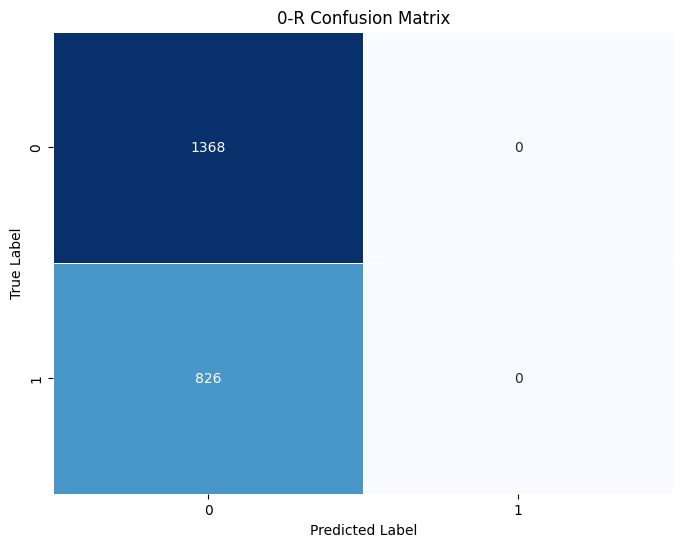

In [24]:
# Compute confusion matrix
print("Zero-R model")
cm = confusion_matrix(y_test, Zero_R_pred)
cm_df = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('0-R Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Random Forest Classifier


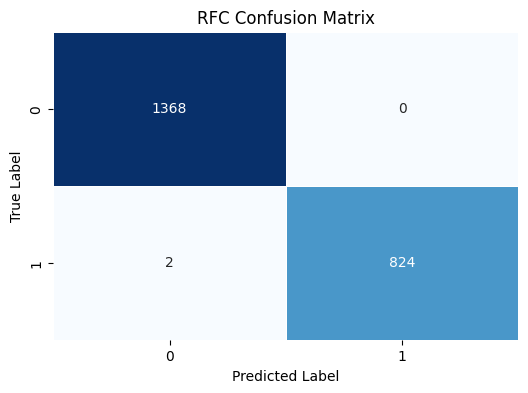

In [25]:
# Compute confusion matrix
print("Random Forest Classifier")
cm = confusion_matrix(y_test, rf_y_pred_train)
cm_df = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.title('RFC Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [26]:
# Finding Accuracy using cross validation
cv_scores = cross_val_score(rf_model, X, y, cv=5)
print("Cross-Validation Scores for Each Fold:", cv_scores)
print(f"Mean CV Accuracy: {cv_scores.mean():.5f}")

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was exp

Cross-Validation Scores for Each Fold: [1.         0.99817601 0.99863201 0.99817601 0.999544  ]
Mean CV Accuracy: 0.99891


In [27]:
# Scorings for cross-validation
scoring = {'f1': 'f1', 'precision': 'precision', 'recall': 'recall'}

# Cross-validation to confirm accuracy
scores = cross_validate(rf_model, X, y, cv=5, scoring=scoring, return_train_score=False)

# Results
print(f"F1 Scores: {scores['test_f1']}")
print(f"Precision Scores: {scores['test_precision']}")
print(f"Recall Scores: {scores['test_recall']}")

# Average Scores
print(f"Average F1 Score: {scores['test_f1'].mean()}")
print(f"Average Precision: {scores['test_precision'].mean()}")
print(f"Average Recall: {scores['test_recall'].mean()}")

/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/chin_chee_henn/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was exp

F1 Scores: [1.         0.99749059 0.99812148 0.99749373 0.99937383]
Precision Scores: [1.         1.         0.99874687 0.99874529 1.        ]
Recall Scores: [1.         0.99499374 0.99749687 0.99624531 0.99874844]
Average F1 Score: 0.998495925548337
Average Precision: 0.9994984324047257
Average Recall: 0.9974968710888611


In [28]:
# Zero-R Test
zero_R_pred_test = [y_freq]*len(final_test_data)
zero_R_pred_test = pd.DataFrame(zero_R_pred_test, columns=['IsFraud'])  
zero_R_solution = pd.concat([transactionID_test, zero_R_pred_test], axis=1)

In [29]:
# Random Forest Classifier Test
rfc_y_pred_test = rf_model.predict(final_test_data)
rfc_y_pred_test = pd.DataFrame(rfc_y_pred_test, columns=['IsFraud'])  
rfc_solution = pd.concat([transactionID_test, rfc_y_pred_test], axis=1)

### Saving Solutions into Submission Format

In [30]:
import os

# Creating folder if folder does not exist
folder_path = '../results'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Saving to /data/raw
rfc_file_path = os.path.join(folder_path, 'rfc_solution.csv')
zero_R_file_path = os.path.join(folder_path, 'zero_R_solution.csv')

rfc_solution.to_csv(rfc_file_path, index=False)
zero_R_solution.to_csv(zero_R_file_path, index=False)